<a href="https://colab.research.google.com/github/pcesc/REPA_TRAB/blob/main/Trab_REPA_Gelinton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predição de AVC (Stroke Prediction)

Objetivo: construir um modelo de classificação que estime a probabilidade de um(a) paciente ter sofrido AVC (stroke = 1) com base em atributos demográficos e clínicos.




## 1. Contextualização do dataset

Vamos trabalhar com um dataset público amplamente utilizado em exercícios de Stroke Prediction (predição de AVC).  
Cada linha representa um paciente, com variáveis como:

- `age` (idade)  
- `hypertension` (hipertensão)  
- `heart_disease` (doença cardíaca)  
- `avg_glucose_level` (nível médio de glicose)  
- `bmi` (IMC)  
- informações demográficas e de estilo de vida (`gender`, `smoking_status`, etc.)  
- alvo: `stroke` (0 = não teve AVC, 1 = teve AVC)

### Por que este problema é interessante?
- É um problema de classificação binária com forte desbalanceamento de classes.
- Em contextos de saúde, métricas como recall/sensibilidade e AUC podem ser mais relevantes do que apenas acurácia.




In [ ]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import urllib.request
import warnings

warnings.filterwarnings("ignore")
sns.set_theme()

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Versões:")
import sklearn
print("pandas:", pd.__version__)
print("numpy :", np.__version__)
print("sklearn:", sklearn.__version__)

Versões:
pandas: 2.3.3
numpy : 2.3.5
sklearn: 1.8.0


## 2. Carregamento dos dados


In [ ]:
# Dados baixados e importados diretamente no menu esquerdo "arquivos".

DATA_PATH = Path("healthcare-dataset-stroke-data.csv")

def robust_read_csv(path: Path) -> pd.DataFrame:
    """Lê o dataset de forma robusta.

    Alguns espelhos do dataset podem vir com separador vírgula (CSV clássico),
    enquanto outros podem vir com separação por espaço/tab.
    """
    # Tentativa 1: separador vírgula
    df_try = pd.read_csv(path, na_values=["N/A", "NA", ""])
    if df_try.shape[1] == 1:
        # Tentativa 2: whitespace (espaço/tab)
        df_try = pd.read_csv(path, sep=r"\s+", na_values=["N/A", "NA", ""])
    return df_try

df = robust_read_csv(DATA_PATH)

df.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## 3. Exploração inicial

Vamos começar com:
- dimensão do dataset
- tipos de variáveis
- estatísticas descritivas
- distribuição do alvo stroke
- dados faltantes


In [ ]:
print("Formato (linhas, colunas):", df.shape)
display(df.sample(5, random_state=RANDOM_STATE))

print("\nTipos de dados:")
display(df.dtypes)

print("\nResumo (info):")
df.info()

print("\nEstatísticas (numéricas):")
display(df.describe(include=[np.number]).T)

print("\nEstatísticas (categóricas):")
display(df.describe(include=[object]).T)


Formato (linhas, colunas): (5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
4688,40041,Male,31.0,0,0,No,Self-employed,Rural,64.85,23.0,Unknown,0
4478,55244,Male,40.0,0,0,Yes,Self-employed,Rural,65.29,28.3,never smoked,0
3849,70992,Female,8.0,0,0,No,children,Urban,74.42,22.5,Unknown,0
4355,38207,Female,79.0,1,0,Yes,Self-employed,Rural,76.64,19.5,never smoked,0
3826,8541,Female,75.0,0,0,Yes,Govt_job,Rural,94.77,27.2,never smoked,0



Tipos de dados:


,0
id,int64
gender,object
age,float64
hypertension,int64
heart_disease,int64
ever_married,object
work_type,object
Residence_type,object
avg_glucose_level,float64
bmi,float64



Resumo (info):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB

Estatísticas (numéricas):


,count,mean,std,min,25%,50%,75%,max
id,5110.0,36517.829354,21161.721625,67.00,17741.250,36932.000,54682.00,72940.00
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00



Estatísticas (categóricas):


,count,unique,top,freq
gender,5110,3,Female,2994
ever_married,5110,2,Yes,3353
work_type,5110,5,Private,2925
Residence_type,5110,2,Urban,2596
smoking_status,5110,4,never smoked,1892


,contagem,percentual (%)
stroke,,
0,4861,95.13
1,249,4.87


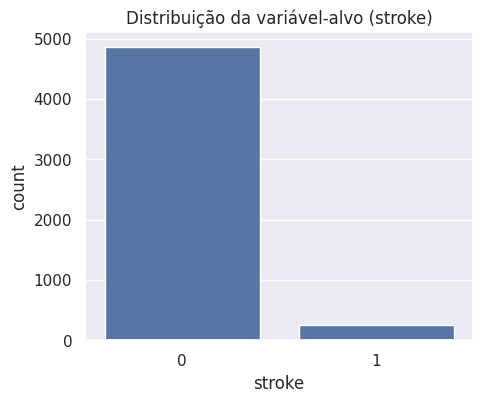

In [ ]:
# Distribuição do alvo
target_col = "stroke"
target_counts = df[target_col].value_counts(dropna=False)
target_pct = df[target_col].value_counts(normalize=True, dropna=False) * 100

display(pd.DataFrame({"contagem": target_counts, "percentual (%)": target_pct.round(2)}))

plt.figure(figsize=(5,4))
sns.countplot(data=df, x=target_col)
plt.title("Distribuição da variável-alvo (stroke)")
plt.show()


,faltantes,faltantes (%)
bmi,201,3.93


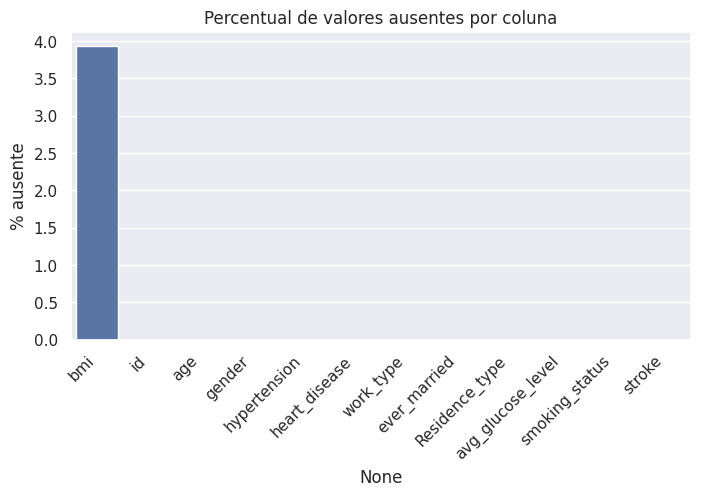

In [ ]:
# Dados faltantes
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)

missing_table = pd.DataFrame({"faltantes": missing, "faltantes (%)": missing_pct.round(2)})
display(missing_table[missing_table["faltantes"] > 0])

plt.figure(figsize=(8,4))
sns.barplot(x=missing_table.index, y=missing_table["faltantes (%)"])
plt.xticks(rotation=45, ha="right")
plt.title("Percentual de valores ausentes por coluna")
plt.ylabel("% ausente")
plt.show()


## 4. Visualizações para entender o comportamento do dataset

Aqui vamos olhar:
- distribuição de variáveis numéricas (idade, glicose, IMC)
- relação de algumas variáveis com o alvo (stroke)
- possíveis outliers (boxplots)


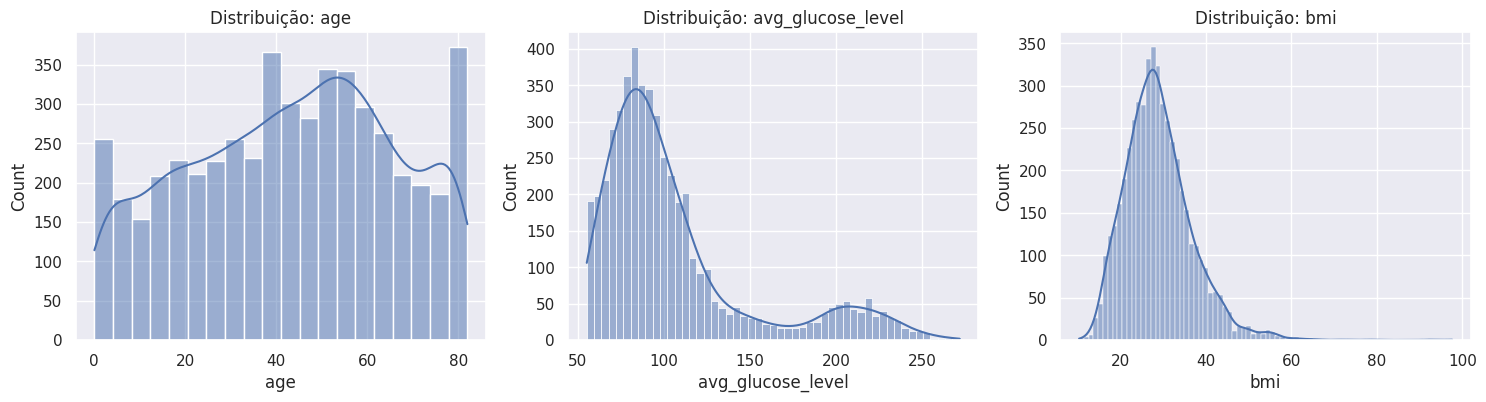

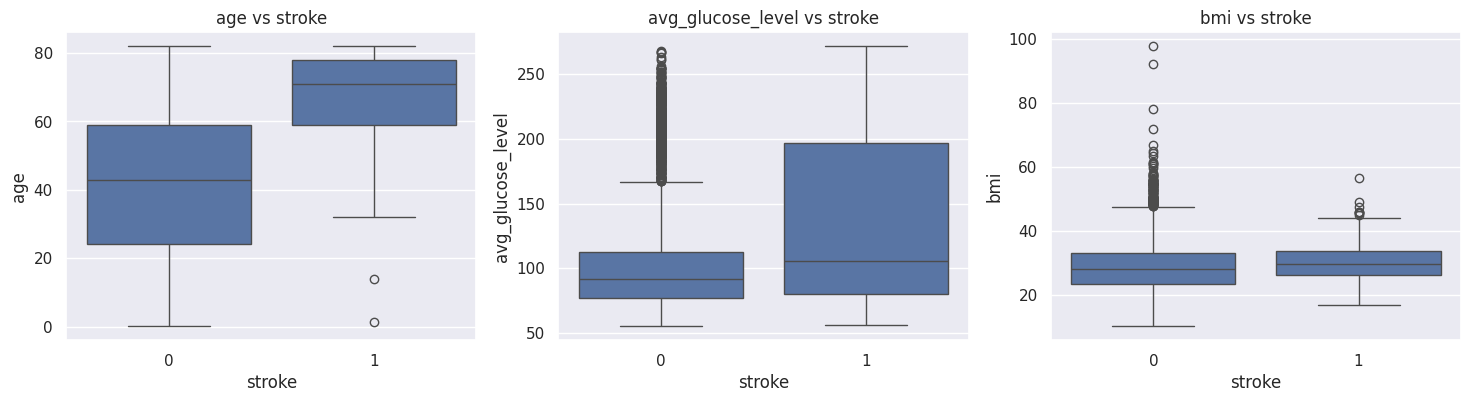

In [ ]:
num_cols = ["age", "avg_glucose_level", "bmi"]
fig, axes = plt.subplots(1, 3, figsize=(18,4))

for ax, col in zip(axes, num_cols):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f"Distribuição: {col}")

plt.show()

# Boxplots por classe
fig, axes = plt.subplots(1, 3, figsize=(18,4))
for ax, col in zip(axes, num_cols):
    sns.boxplot(data=df, x=target_col, y=col, ax=ax)
    ax.set_title(f"{col} vs {target_col}")
plt.show()


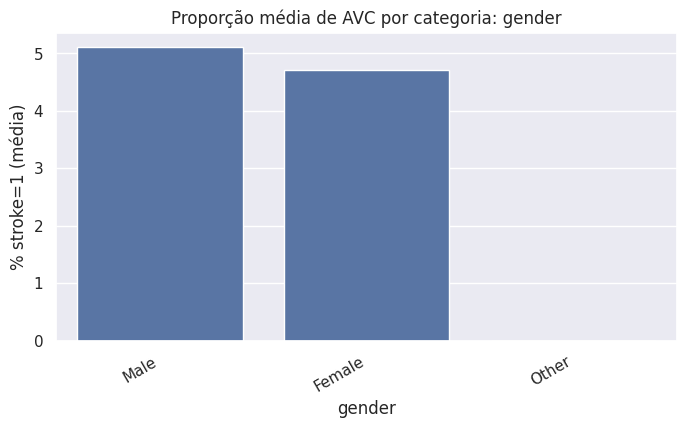

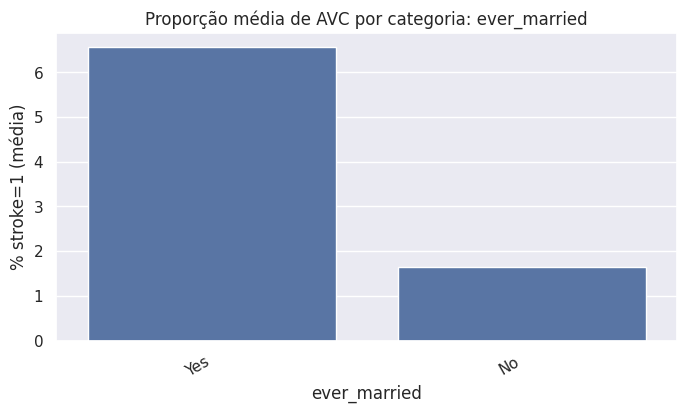

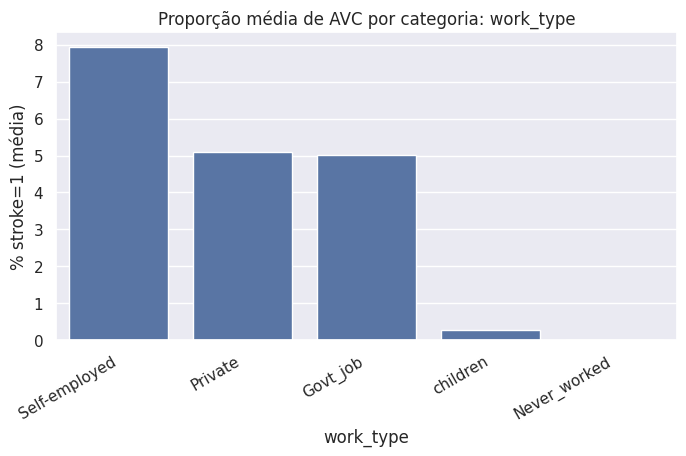

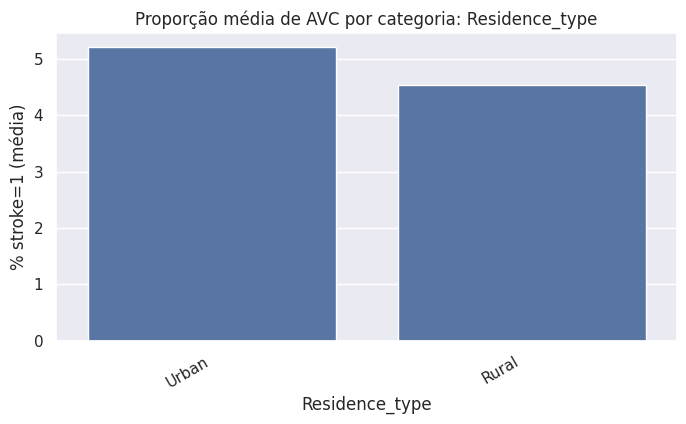

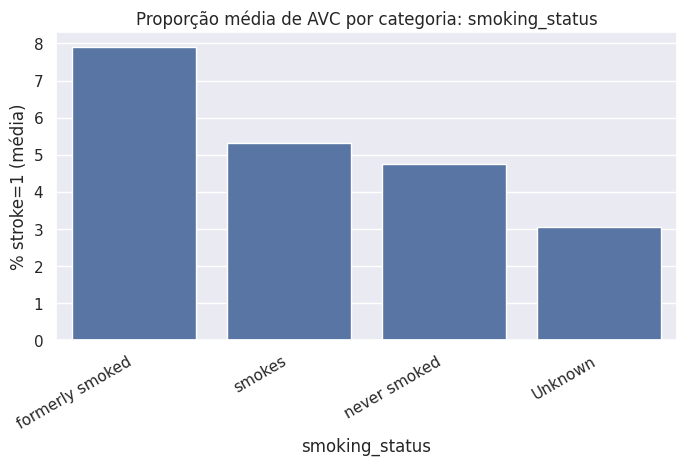

In [ ]:
# Variáveis categóricas: proporção de stroke por categoria (visual simples)
cat_cols = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]

for col in cat_cols:
    plt.figure(figsize=(8,4))
    # normaliza por categoria para ver proporções
    prop = (df.groupby(col)[target_col].mean().sort_values(ascending=False) * 100)
    sns.barplot(x=prop.index, y=prop.values)
    plt.xticks(rotation=30, ha="right")
    plt.ylabel("% stroke=1 (média)")
    plt.title(f"Proporção média de AVC por categoria: {col}")
    plt.show()


### Correlação

A correlação não prova causalidade, mas ajuda a entender relações lineares,  identificar variáveis redundantes e levantar hipóteses para a modelagem.

Vamos olhar correlação entre variáveis numéricas e o alvo stroke.


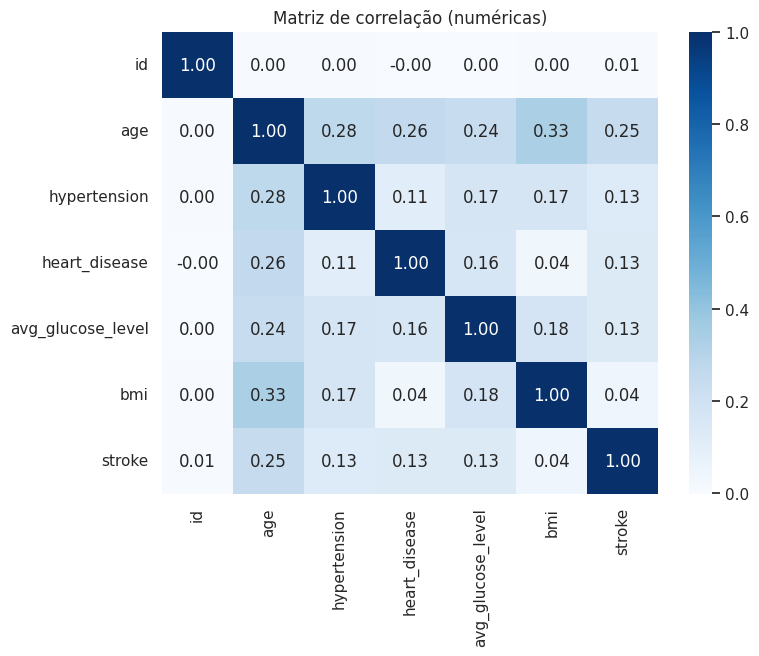

In [ ]:
# Correlação (apenas numéricas)
num_for_corr = df.select_dtypes(include=[np.number]).columns.tolist()

# Garantir que o alvo esteja na lista (se for numérico)
if target_col not in num_for_corr:
    num_for_corr.append(target_col)

corr = df[num_for_corr].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="Blues")
plt.title("Matriz de correlação (numéricas)")
plt.show()


## 5. Preparação dos dados

### Decisões de pré-processamento
1) Remoção da coluna id: essa variável funciona apenas como identificador dos registros e não contribui para a previsão. Por isso, foi removida para evitar a introdução de ruído no modelo.

2) Tratamento de valores ausentes:

- Para a variável numérica bmi, foi utilizada a mediana, pois é menos sensível a valores extremos.

- Para as variáveis categóricas, os valores faltantes foram preenchidos com a moda, ou seja, o valor mais frequente.

3) Codificação das variáveis categóricas: foi aplicado o One-Hot Encoding, evitando que o modelo interprete categorias como se tivessem uma ordem numérica.

4) Padronização dos dados: utilizou-se o StandardScaler, já que alguns modelos, como regressão logística e SVM, são sensíveis à escala das variáveis.

5) Divisão entre treino e teste: os dados foram separados de forma estratificada, garantindo que a proporção da variável stroke fosse mantida nos dois conjuntos.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# 1) Preparar cópia para modelagem
df_model = df.copy()

# Remove coluna id se existir
if "id" in df_model.columns:
    df_model = df_model.drop(columns=["id"])

# 2) Engenharia de features (simples e justificada)
# - bmi_missing: às vezes "estar ausente" é um sinal (ex.: não medido)
# - age_group: discretização pode capturar efeitos não-lineares por faixa etária
if "bmi" in df_model.columns:
    df_model["bmi_missing"] = df_model["bmi"].isna().astype(int)

if "age" in df_model.columns:
    df_model["age_group"] = pd.cut(
        df_model["age"],
        bins=[0, 18, 35, 50, 65, 120],
        labels=["0-18", "19-35", "36-50", "51-65", "66+"],
        include_lowest=True
    )

# 3) Separar X e y
X = df_model.drop(columns=[target_col])
y = df_model[target_col].astype(int)

# 4) Detectar colunas numéricas e categóricas
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numéricas:", numeric_features)
print("Categóricas:", categorical_features)

# 5) Pré-processadores
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# 6) Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Treino:", X_train.shape, "Teste:", X_test.shape)
print("Taxa de stroke no treino:", y_train.mean().round(4))
print("Taxa de stroke no teste :", y_test.mean().round(4))


Numéricas: ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'bmi_missing']
Categóricas: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'age_group']
Treino: (4088, 12) Teste: (1022, 12)
Taxa de stroke no treino: 0.0487
Taxa de stroke no teste : 0.0489


## 6. Baseline

Antes de partir para modelos mais complexos, é importante criar um baseline simples para servir como referência.
Neste trabalho, foi utilizado o DummyClassifier, que funciona de maneira bem básica, podendo sempre prever a classe majoritária ou fazer previsões de acordo com a distribuição das classes no conjunto de dados.

Esse tipo de modelo ajuda a entender melhor a dificuldade do problema e evita interpretações enganosas, como obter uma acurácia aparentemente alta apenas por causa do desbalanceamento dos dados.


Baseline (majoritária) — Relatório:
              precision    recall  f1-score   support

           0     0.9511    1.0000    0.9749       972
           1     0.0000    0.0000    0.0000        50

    accuracy                         0.9511      1022
   macro avg     0.4755    0.5000    0.4875      1022
weighted avg     0.9045    0.9511    0.9272      1022



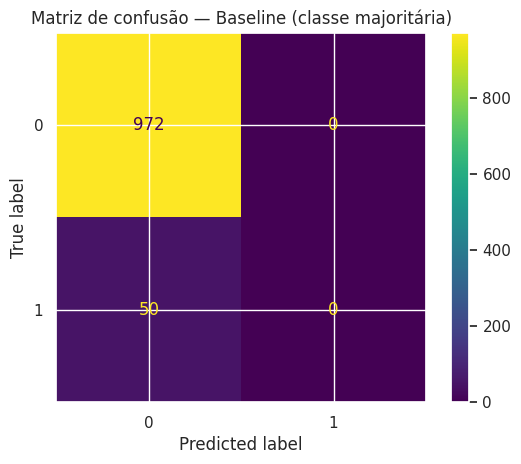

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

dummy = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)),
])

dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

print("Baseline (majoritária) — Relatório:")
print(classification_report(y_test, y_pred_dummy, digits=4))

cm = confusion_matrix(y_test, y_pred_dummy)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format="d")
plt.title("Matriz de confusão — Baseline (classe majoritária)")
plt.show()


## 7. Modelagem

Nesta etapa, foram testados alguns modelos clássicos de classificação, com o objetivo de comparar seus desempenhos:

1) Regressão Logística

- É um modelo de fácil interpretação, já que seus coeficientes ajudam a entender a influência de cada variável.

- Necessita de padronização dos dados, que já foi aplicada no pipeline.

- Para lidar com o desbalanceamento das classes, foi utilizado o parâmetro class_weight='balanced'.

2) Random Forest

- Consegue capturar relações não lineares e interações entre as variáveis.

- Não é tão sensível à escala dos dados, mas o mesmo pipeline foi mantido para garantir consistência nos experimentos.

- Assim como na regressão logística, também foi utilizado class_weight='balanced'.



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score
)

models = {
    "LogReg (balanced)": LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        random_state=RANDOM_STATE,
    ),
    "RandomForest (balanced)": RandomForestClassifier(
        n_estimators=400,
        random_state=RANDOM_STATE,
        class_weight="balanced",
        n_jobs=-1,
    ),
}

def evaluate_on_test(pipeline, X_test, y_test):
    y_pred = pipeline.predict(X_test)
    # Para AUC precisamos de probabilidade/score
    if hasattr(pipeline, "predict_proba"):
        y_score = pipeline.predict_proba(X_test)[:, 1]
    else:
        y_score = pipeline.decision_function(X_test)

    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_score),
        "pr_auc": average_precision_score(y_test, y_score),
    }

results = []
pipelines = {}

for name, model in models.items():
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)
    pipelines[name] = pipe

    metrics = evaluate_on_test(pipe, X_test, y_test)
    metrics["model"] = name
    results.append(metrics)

results_df = pd.DataFrame(results).set_index("model").sort_values("roc_auc", ascending=False)
display(results_df.style.format("{:.4f}"))


,accuracy,precision,recall,f1,roc_auc,pr_auc
model,,,,,,
LogReg (balanced),0.7319,0.1340,0.8200,0.2303,0.8386,0.2317
RandomForest (balanced),0.9501,0.0000,0.0000,0.0000,0.7856,0.1566


## 8. Cross-Validation

Avaliar o modelo usando apenas uma única divisão entre treino e teste pode gerar resultados instáveis. Por isso, foi utilizada a validação cruzada estratificada, que ajuda a obter uma melhor estimativa mais confiável do desempenho do modelo e diminui a dependência de um único split específico.

Neste trabalho, foi aplicado o StratifiedKFold e foi avalida múltiplas métricas.


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_validate

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc",
    "pr_auc": "average_precision",
}

cv_results = []

for name, model in models.items():
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", model)])
    scores = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)

    row = {"model": name}
    for k, v in scores.items():
        if k.startswith("test_"):
            row[k.replace("test_", "")] = np.mean(v)
            row[k.replace("test_", "") + "_std"] = np.std(v)
    cv_results.append(row)

cv_df = pd.DataFrame(cv_results).set_index("model").sort_values("roc_auc", ascending=False)
display(cv_df.style.format("{:.4f}"))


,accuracy,accuracy_std,precision,precision_std,recall,recall_std,f1,f1_std,roc_auc,roc_auc_std,pr_auc,pr_auc_std
model,,,,,,,,,,,,
LogReg (balanced),0.7378,0.0053,0.1322,0.0070,0.7869,0.0392,0.2263,0.0118,0.8460,0.0184,0.2214,0.0439
RandomForest (balanced),0.9511,0.0006,0.3000,0.2449,0.0160,0.0150,0.0302,0.0279,0.8169,0.0144,0.1674,0.0175


## 9. Seleção do modelo

Neste trabalho, o melhor modelo é selecionado automaticamente com base no valor médio de roc_auc obtido na validação cruzada.


In [ ]:
best_model_name = cv_df.index[0]
best_pipe = pipelines[best_model_name]

print("Modelo selecionado:", best_model_name)


Modelo selecionado: LogReg (balanced)


## 10. Avaliação detalhada no conjunto de teste

Após a escolha do melhor modelo, é realizada uma avaliação mais detalhada utilizando o conjunto de teste. Nesta etapa, são analisados:

- o relatório de classificação, com métricas como precisão, recall e f1-score;

- a matriz de confusão, para entender melhor os acertos e erros do modelo;

- as curvas ROC e Precision-Recall, que ajudam a avaliar o desempenho do classificador sob diferentes limiares de decisão.


Relatório de classificação (teste):
              precision    recall  f1-score   support

           0     0.9874    0.7274    0.8377       972
           1     0.1340    0.8200    0.2303        50

    accuracy                         0.7319      1022
   macro avg     0.5607    0.7737    0.5340      1022
weighted avg     0.9457    0.7319    0.8080      1022



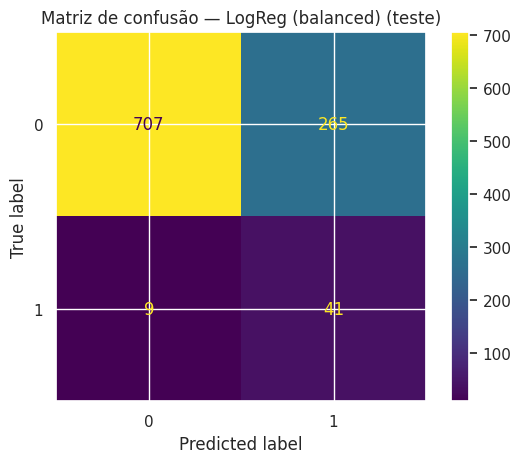

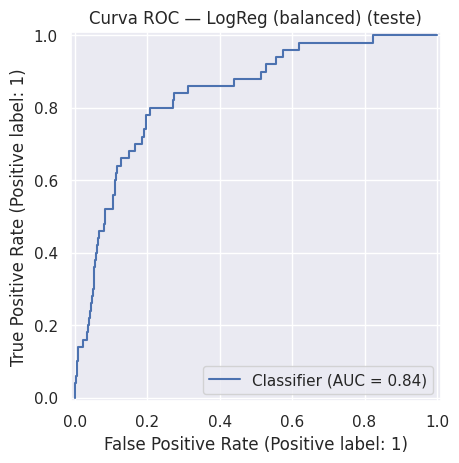

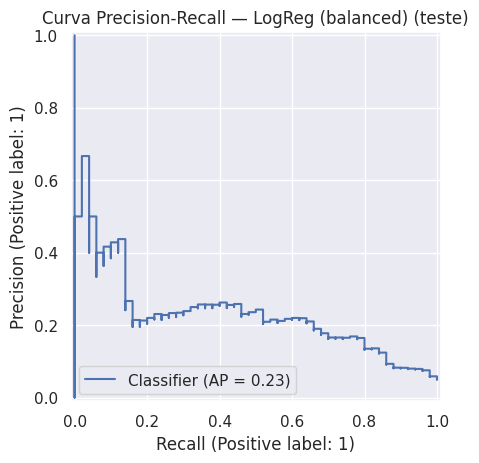

ROC AUC (teste): 0.8386
PR AUC  (teste): 0.2317


In [ ]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

y_pred = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)[:, 1]

print("Relatório de classificação (teste):")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(values_format="d")
plt.title(f"Matriz de confusão — {best_model_name} (teste)")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title(f"Curva ROC — {best_model_name} (teste)")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.title(f"Curva Precision-Recall — {best_model_name} (teste)")
plt.show()

roc_auc = roc_auc_score(y_test, y_proba)
pr_auc  = average_precision_score(y_test, y_proba)

print(f"ROC AUC (teste): {roc_auc:.4f}")
print(f"PR AUC  (teste): {pr_auc:.4f}")


## 11. Ajuste de threshold

Por padrão, o método predict() utiliza um limiar de decisão (threshold) de 0.5. No entanto, em conjuntos de dados desbalanceados, esse valor nem sempre é o mais adequado. Ajustar o threshold pode ser uma boa estratégia para aumentar o recall, identificando um maior número de casos de AVC ou equilibrar melhor precisão e recall, de acordo com o objetivo da análise.

A seguir, são avaliados diferentes valores de threshold, e é selecionado aquele que apresenta o melhor F1-score.


,threshold,precision,recall,f1
0,0.05,0.0759,0.9600,0.1408
1,0.10,0.0774,0.9600,0.1433
2,0.15,0.0816,0.9200,0.1498
3,0.20,0.0864,0.8800,0.1574
4,0.25,0.0915,0.8600,0.1654
5,0.30,0.0977,0.8600,0.1755
6,0.35,0.1036,0.8600,0.1849
7,0.40,0.1147,0.8600,0.2024
8,0.45,0.1228,0.8400,0.2143
9,0.50,0.1340,0.8200,0.2303


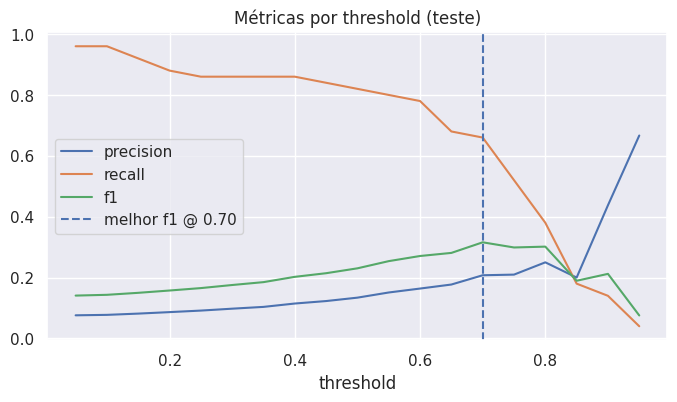

Melhor threshold (por F1): 0.7


In [ ]:
thresholds = np.linspace(0.05, 0.95, 19)
rows = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    rows.append({
        "threshold": t,
        "precision": precision_score(y_test, y_pred_t, zero_division=0),
        "recall": recall_score(y_test, y_pred_t, zero_division=0),
        "f1": f1_score(y_test, y_pred_t, zero_division=0),
    })

thr_df = pd.DataFrame(rows)
best_t = thr_df.loc[thr_df["f1"].idxmax(), "threshold"]

display(thr_df.style.format({"threshold":"{:.2f}", "precision":"{:.4f}", "recall":"{:.4f}", "f1":"{:.4f}"}))

plt.figure(figsize=(8,4))
plt.plot(thr_df["threshold"], thr_df["precision"], label="precision")
plt.plot(thr_df["threshold"], thr_df["recall"], label="recall")
plt.plot(thr_df["threshold"], thr_df["f1"], label="f1")
plt.axvline(best_t, linestyle="--", label=f"melhor f1 @ {best_t:.2f}")
plt.xlabel("threshold")
plt.title("Métricas por threshold (teste)")
plt.legend()
plt.show()

print("Melhor threshold (por F1):", round(float(best_t), 2))


## 12. Interpretação do modelo

Na Regressão Logística, é possível analisar os coeficientes do modelo, que representam o efeito linear de cada variável após a padronização e a aplicação do one-hot encoding.

Já no Random Forest, a interpretação pode ser feita por meio da importância das variáveis, indicando quais atributos mais contribuíram para as decisões do modelo.

Como foi utilizado um pipeline com ColumnTransformer e OneHotEncoder, é necessário, antes dessa análise, recuperar os nomes das variáveis resultantes após as transformações aplicadas aos dados.


Total de features após one-hot: 27


,feature,coef
0,num__age,1.662495
15,cat__work_type_children,1.084388
25,cat__age_group_51-65,0.992748
24,cat__age_group_36-50,0.689148
26,cat__age_group_66+,0.669733
5,num__bmi_missing,0.341861
21,cat__smoking_status_smokes,0.203444
1,num__hypertension,0.194955
3,num__avg_glucose_level,0.172816
2,num__heart_disease,0.059867


,feature,coef
8,cat__gender_Other,-0.003517
19,cat__smoking_status_formerly smoked,-0.005869
6,cat__gender_Female,-0.061959
12,cat__work_type_Never_worked,-0.105411
17,cat__Residence_type_Urban,-0.121413
16,cat__Residence_type_Rural,-0.193008
20,cat__smoking_status_never smoked,-0.211989
7,cat__gender_Male,-0.248945
18,cat__smoking_status_Unknown,-0.300007
13,cat__work_type_Private,-0.314499


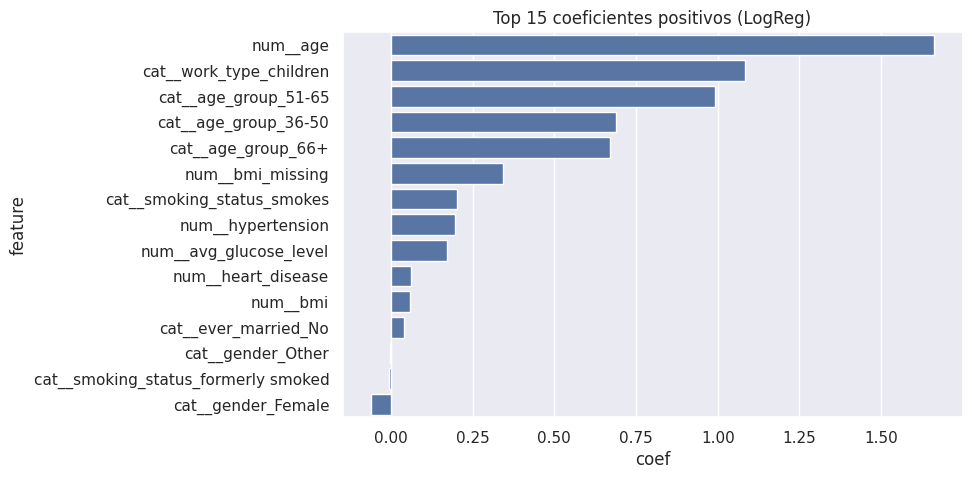

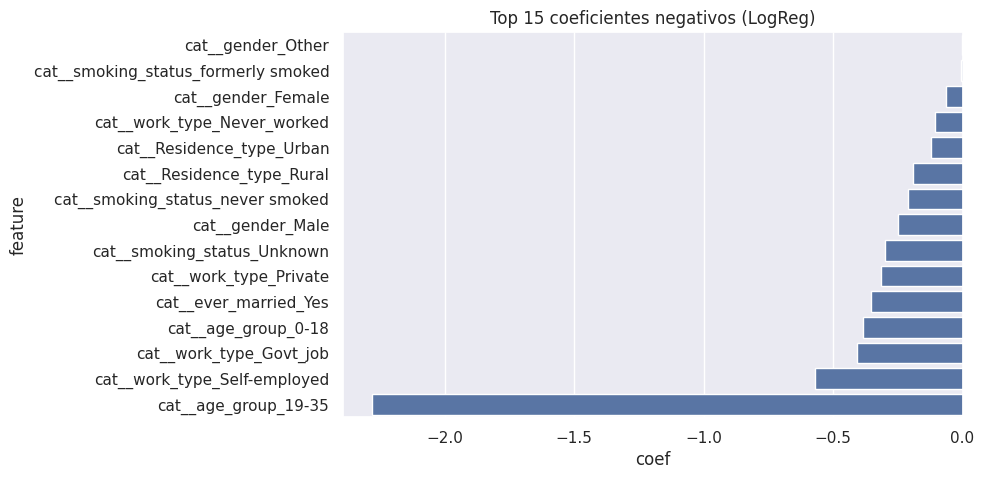

In [ ]:
# Recuperar nomes de features após o pré-processamento

def get_feature_names(preprocess: ColumnTransformer) -> np.ndarray:
    try:
        return preprocess.get_feature_names_out()
    except Exception:
        # fallback simples
        names = []
        for name, trans, cols in preprocess.transformers_:
            if name == "remainder":
                continue
            if hasattr(trans, "get_feature_names_out"):
                if isinstance(cols, (list, tuple, np.ndarray)):
                    try:
                        names.extend(trans.get_feature_names_out(cols))
                    except Exception:
                        names.extend([f"{name}__{c}" for c in cols])
                else:
                    names.extend(trans.get_feature_names_out())
            else:
                if isinstance(cols, (list, tuple, np.ndarray)):
                    names.extend([f"{name}__{c}" for c in cols])
                else:
                    names.append(str(cols))
        return np.array(names)

feature_names = get_feature_names(best_pipe.named_steps["preprocess"])
print("Total de features após one-hot:", len(feature_names))

# Interpretação conforme o tipo de modelo
final_model = best_pipe.named_steps["model"]

if hasattr(final_model, "coef_"):
    coefs = final_model.coef_.ravel()
    coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs}).sort_values("coef", ascending=False)
    display(coef_df.head(15))
    display(coef_df.tail(15))

    plt.figure(figsize=(8,5))
    sns.barplot(data=coef_df.head(15), x="coef", y="feature")
    plt.title("Top 15 coeficientes positivos (LogReg)")
    plt.show()

    plt.figure(figsize=(8,5))
    sns.barplot(data=coef_df.tail(15), x="coef", y="feature")
    plt.title("Top 15 coeficientes negativos (LogReg)")
    plt.show()

elif hasattr(final_model, "feature_importances_"):
    imp = final_model.feature_importances_
    imp_df = pd.DataFrame({"feature": feature_names, "importance": imp}).sort_values("importance", ascending=False)
    display(imp_df.head(20))

    plt.figure(figsize=(8,6))
    sns.barplot(data=imp_df.head(20), x="importance", y="feature")
    plt.title("Top 20 importâncias (Random Forest)")
    plt.show()
else:
    print("Modelo não suporta interpretação direta por coeficientes ou feature_importances_.")


## 13. Conclusão

### Resumo dos achados
Neste trabalho, foi desenvolvido um pipeline de Machine Learning para o problema de predição de AVC (stroke), utilizando um dataset com variáveis clínicas e socioeconômicas. O processo envolveu exploração dos dados, tratamento de valores ausentes, codificação de variáveis categóricas, padronização quando necessária, divisão adequada entre treino e teste e comparação entre modelos.


### Comparação com a baseline
A baseline majoritária, que prevê todos os exemplos como “sem AVC”, apresentou acurácia de 95,11%. No entanto, essa performance é enganosa, pois o modelo não conseguiu identificar nenhum caso de AVC, apresentando recall e F1-score iguais a zero para a classe positiva. Isso evidencia que a acurácia, sozinha, não é uma métrica adequada para este problema e reforça a necessidade de avaliar métricas focadas na classe minoritária.


### Modelo final e desempenho
O modelo selecionado foi a Regressão Logística com balanceamento de classes (LogReg balanced), escolhida por apresentar um bom equilíbrio entre desempenho e interpretabilidade.
No conjunto de teste, o modelo obteve:

ROC AUC = 0.8386, indicando boa capacidade geral de discriminação entre as classes.

PR AUC = 0.2317, métrica especialmente importante em contextos desbalanceados.

Para melhorar o equilíbrio entre precision e recall, foi realizado ajuste do limiar de decisão, sendo escolhido o threshold de 0.7, que maximizou o F1-score da classe positiva. Com esse ajuste, o modelo alcançou:
- Recall de 0.82 para a classe AVC, indicando que a maioria dos casos positivos foi corretamente identificada;
- Precision mais baixa (0.134), refletindo o aumento de falsos positivos, algo esperado nesse tipo de trade-off.

Apesar da redução da acurácia global para 73,19%, o modelo passou a cumprir melhor o objetivo do problema, que é identificar indivíduos em risco.


### Interpretação dos resultados
Os resultados mostram claramente o trade-off entre recall e precision. Em um contexto de saúde, é preferível errar sinalizando um possível AVC que não se confirme (falso positivo) do que deixar de identificar um caso real (falso negativo). Dessa forma, o ajuste de threshold se mostrou uma etapa necessária para alinhar o modelo ao objetivo prático da aplicação.


### Limitações
Entre as principais limitações do estudo, destacam-se:
- O forte desbalanceamento do dataset, que dificulta a obtenção simultânea de alta precisão e alto recall para a classe positiva;
- A avaliação baseada em um único conjunto de teste, sem validação externa;
- A ausência de informações adicionais que poderiam enriquecer o modelo, como dados clínicos mais detalhados ou históricos temporais.


### Próximos passos
Como trabalhos futuros, sugere-se:
- Avaliar outros critérios de ajuste de threshold, priorizando diferentes objetivos clínicos;
- Testar técnicas de calibração de probabilidades para tornar as saídas do modelo mais interpretáveis;
- Analisar o desempenho do modelo em subgrupos (por idade, sexo, etc.) para investigar possíveis vieses;
- Realizar validação externa com dados de outras fontes.
